In [58]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import pandas as pd
import random as random
from calibration_util import *
%matplotlib inline

In [59]:
def scale(data, col):
    data[col] = (data[col]-data[col].min()) / (data[col].max() - data[col].min())
    
# generate regression dataset
def generate(n_points, n_attr, n, r):
    data = pd.DataFrame()
    X1, y1 = make_regression(n_samples=n_points, n_features=n_attr, noise=n, random_state=r)
    g1 = np.zeros(int(len(X1)/2))
    g2 = np.ones(int(len(X1)/2))
    g = np.append(g1, g2)
    d1 = np.insert(X1, 5, values=y1, axis=1)
    data = pd.DataFrame(d1)
    data = data.sample(frac=1)
    data.columns = ['x0','x1','x2','x3','x4','y']
    data['g']=g
    #set y between 0 and 1,sort
    scale(data, 'y')
    data.sort_values('y', inplace=True)
    return data

In [60]:
data = generate(10000,5,0.2,99)

In [61]:
data.head()

,x0,x1,x2,x3,x4,y,g
8679,-0.620717,-0.634455,-1.145017,-3.735466,-3.675414,0.000000,1.0
5679,-1.284862,-0.993106,-1.043758,-2.310001,-2.566773,0.097937,1.0
8570,-2.189603,-1.227665,0.285228,-1.915179,-2.288695,0.110173,0.0
1693,-2.207989,-1.776297,-0.664650,-1.167179,-2.121819,0.114049,0.0
2350,-1.904276,-2.950238,-1.165516,-1.040818,-0.964168,0.117402,0.0


In [62]:
def under_rank(data, sample, scale, group):
    
    #randomly select some percentage of group to be under ranked
    data2 = data.copy()
    for i in range(len(data)):
        if(data2.iloc[i]['g'] == group):
            if(random.random() <sample):
                data2.iloc[i]['y'] = data2.iloc[i]['y']*scale

    data2.sort_values('y', inplace=True)
    return data2

def shift_mean(data, sample, amt, group):
    #shift mean of group by some percentage
    data2 = data.copy()
    for i in range(len(data)):
        if(data2.iloc[i]['g'] == group):
            if(random.random() <sample):
                data2.iloc[i]['y'] = data2.iloc[i]['y']-amt
    scale(data2, 'y')
    return data2

def plot_rank(data):
    cmap = plt.cm.rainbow
    plt.rcParams['figure.figsize'] = (20, 4)
    fig, ax = plt.subplots()
    ax.bar(range(len(data)), data['y'], 0.5, color=cmap((data['g'])))
    ax.set_xlim([0,len(data)])
    ax.set_title("", fontsize=16)
    plt.show()

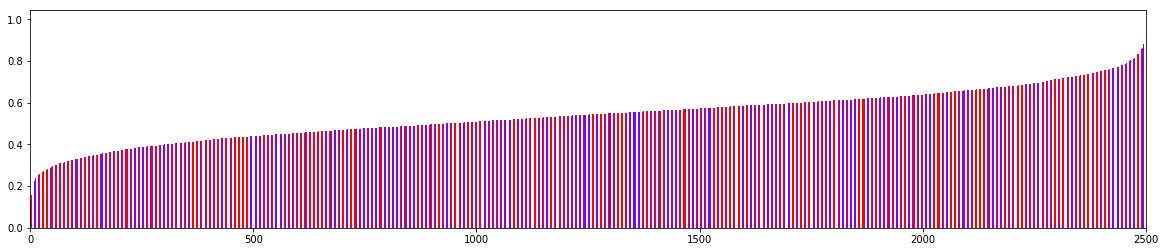

In [63]:
plot_rank(data.sample(frac=0.25).sort_values('y'))

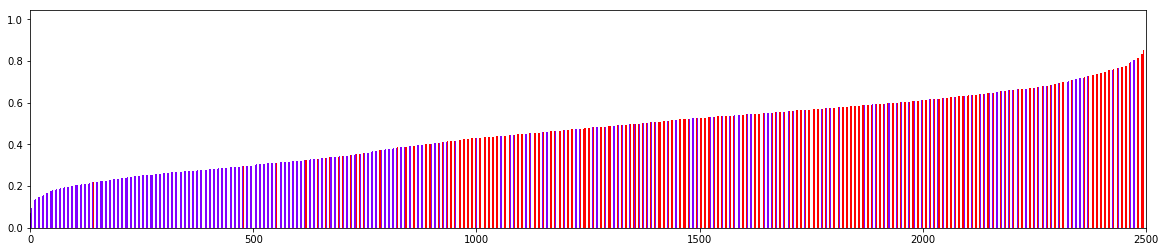

In [64]:
under_data = under_rank(data, .5, .5, 0.)
plot_rank(under_data.sample(frac=0.25).sort_values('y'))

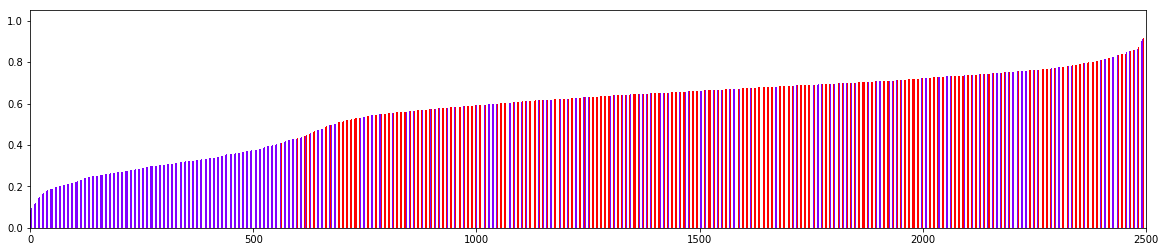

In [65]:
#shifting doesn't give you a smooth distribution, so scaling is preferred
shift_data = shift_mean(data, .5, .5, 0.)
plot_rank(shift_data.sample(frac=0.25).sort_values('y'))

In [66]:
df = data[['y','g']]
df['y_pred'] =under_data['y']

C:\Users\Caitlin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [67]:
df.sort_index(inplace=True)
df.head()

C:\Users\Caitlin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,y,g,y_pred
0,0.651169,1.0,0.651169
1,0.796716,0.0,0.398358
2,0.547534,0.0,0.273767
3,0.682236,1.0,0.682236
4,0.691705,1.0,0.691705


In [68]:
def get_calibrated_predictions(train,test):
    
    ir = IsotonicRegression( out_of_bounds = 'clip' )
    ir.fit(train['y_pred'], train['y'])
    
    return ir.transform(test['y_pred'])  
    
def get_groupwise_calibrated_predictions(train, test):
    
    y_pred0 = train[train['g']==0.]['y_pred']
    y_pred1 = train[train['g']==1.]['y_pred']
    y_0 = train[train['g']==0.]['y']
    y_1 = train[train['g']==1.]['y']
    ir0 = IsotonicRegression( out_of_bounds = 'clip' )
    ir0.fit(y_pred0, y_0)
    ir1 = IsotonicRegression( out_of_bounds = 'clip' )
    ir1.fit(y_pred1, y_1)
    
    test0 = test[test['g']==0.]['y_pred']
    test1 = test[test['g']==1.]['y_pred']
    return ir0.transform(test0), ir1.transform(test1)

In [84]:
#cross validation,for each split use 25% of the training data for calibration
def cross_validate(df, folds, bins, r):
    cv_errors =pd.DataFrame(columns= ['mse0', 'mse1', 'bin_mse_diff', 'ae0', 'ae1', 'bin_ae_diff', 'oe0',
       'oe1', 'bin_oe_diff', 'ue0', 'ue1', 'bin_ue_diff', 'spear0',
       'spear1', 'bin_spear_diff', 'method', 'iteration'])
    kf = KFold(n_splits=folds, shuffle=True, random_state=r)
    i=0
    for train_index, test_index in kf.split(df):

        train = df.iloc[train_index]
        test = df.iloc[test_index]

#         print("training", len(train[train['g']==0.]))
#         print("training", len(train[train['g']==1.]))
#         print("testing", len(test[test['g']==0.]))
#         print("testing", len(test[test['g']==1.]))

        y_pred_baseline = test['y_pred']

        y_pred_cal = get_calibrated_predictions(train, test)

        y_pred0, y_pred1 = get_groupwise_calibrated_predictions(train, test)
        y_pred_all = np.append(y_pred0, y_pred1)

        y_test0 = test[test['g']==0.]['y']
        y_test1 = test[test['g']==1.]['y']
        y_test_all = np.append(y_test0, y_test1)

        g_test0 = test[test['g']==0.]['g']
        g_test1 = test[test['g']==1.]['g']
        g_test_all = np.append(g_test0, g_test1)

        y_test = np.array(test['y'])
        g_test = np.array(test['g'])

        nbins=bins
        b_errors = get_errors(y_pred_baseline, y_test, g_test, nbins)
        b_errors['method'] = "baseline"
        b_errors['iteration']=i
        print("b: ", i)
        c_errors = get_errors(y_pred_cal, y_test, g_test, nbins)
        c_errors['method'] = "calibrate"
        c_errors['iteration']=i
        print("c: ", i)
        cg_errors = get_errors(y_pred_all, y_test_all, g_test_all, nbins)
        cg_errors['method'] = "calibrate_groups"
        cg_errors['iteration']=i
        print("cg: ", i)

        cv_errors = pd.concat([cv_errors, b_errors, c_errors, cg_errors])
        i+=1
    return cv_errors

In [86]:
cv_errors = cross_validate(df, 5, 5, 99)

b:  0
c:  0
cg:  0
b:  1
c:  1
cg:  1
b:  2
c:  2
cg:  2
b:  3
c:  3
cg:  3
b:  4
c:  4
cg:  4


In [110]:
cv_errors.head()

,mse0,mse1,bin_mse_diff,ae0,ae1,bin_ae_diff,oe0,oe1,bin_oe_diff,ue0,ue1,bin_ue_diff,spear0,spear1,bin_spear_diff,method,iteration
0,0.034086,0.0,0.034086,24.702359,0.0,24.702359,0.0,0.0,0.0,-24.702359,0,24.702359,0.634256,1.0,0.365744,baseline,0
1,0.041302,0.0,0.041302,29.124019,0.0,29.124019,0.0,0.0,0.0,-29.124019,0,29.124019,0.531313,1.0,0.468687,baseline,0
2,0.042878,0.0,0.042878,29.626205,0.0,29.626205,0.0,0.0,0.0,-29.626205,0,29.626205,0.471147,1.0,0.528853,baseline,0
3,0.041481,0.0,0.041481,28.633130,0.0,28.633130,0.0,0.0,0.0,-28.633130,0,28.633130,0.566672,1.0,0.433328,baseline,0
4,0.038357,0.0,0.038357,26.618415,0.0,26.618415,0.0,0.0,0.0,-26.618415,0,26.618415,0.491936,1.0,0.508064,baseline,0


In [109]:
cv_errors[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']] = cv_errors[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs()
cv_errors.groupby("method").mean()

,mse0,mse1,bin_mse_diff,ae0,ae1,bin_ae_diff,oe0,oe1,bin_oe_diff,ue0,bin_ue_diff,spear0,spear1,bin_spear_diff
method,,,,,,,,,,,,,,
baseline,0.039837,0.000000,0.039837,27.967633,0.000000,27.967633,0.000000,0.000000,0.000000,-27.967633,27.967633,0.538468,1.000000,0.461532
calibrate,0.008154,0.003587,0.004567,10.868295,5.739678,5.128617,2.570386,5.737963,3.167577,-8.297909,8.296194,0.636338,0.979153,0.342814
calibrate_groups,0.006682,0.000006,0.006676,9.686437,0.010329,9.676108,4.843543,0.008614,4.834929,-4.842894,4.841179,0.671992,1.000000,0.328008
